In [1]:
#Imports
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

from scipy.stats import t
import scipy.stats as st

import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Creating Engine
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [3]:
#Authentication, Windows
engine = new_engine('mssql', 'LAPTOP-VATEKGMJ', 'AdventureWorks2022', integrated_security=True)

mssql://LAPTOP-VATEKGMJ/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [4]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [5]:
#Creatng connection
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [6]:
#Vilka Schemas finns och vilka tabeller ryms?
inspector = inspect(engine)
schemas = inspector.get_schema_names()
num_Schema=0
num_Tables=0
 
for schemat in schemas:
    tables=inspector.get_table_names(schema=schemat)
    if (len(tables)>0 and schemat != 'dbo'):
        print('Schema:',schemat, 'with',len(tables), 'tables: ')
        num_Schema+=1
        for table in tables:
            print(table)
            num_Tables+=1
        print()
 
print('There are ',num_Schema,' Schemas with tables\n')
print('There are a total of ',num_Tables,' tables in the database')

Schema: HumanResources with 6 tables: 
Department
Employee
EmployeeDepartmentHistory
EmployeePayHistory
JobCandidate
Shift

Schema: Person with 14 tables: 
Address
AddressType
BusinessEntity
BusinessEntityAddress
BusinessEntityContact
ContactType
CountryRegion
EmailAddress
MyPersonPhoneTable
Password
Person
PersonPhone
PhoneNumberType
StateProvince

Schema: Production with 25 tables: 
BillOfMaterials
Culture
Document
Illustration
Location
Product
ProductCategory
ProductCostHistory
ProductDescription
ProductDocument
ProductInventory
ProductListPriceHistory
ProductModel
ProductModelIllustration
ProductModelProductDescriptionCulture
ProductPhoto
ProductProductPhoto
ProductReview
ProductSubcategory
ScrapReason
TransactionHistory
TransactionHistoryArchive
UnitMeasure
WorkOrder
WorkOrderRouting

Schema: Purchasing with 5 tables: 
ProductVendor
PurchaseOrderDetail
PurchaseOrderHeader
ShipMethod
Vendor

Schema: Sales with 19 tables: 
CountryRegionCurrency
CreditCard
Currency
CurrencyRate
Custo

# 1. Deskriptiv sammanfattning
- Allmänna frågor om företagets olika schemas. (insikter för styrning av organisation!)
- Urval av några intressanta queries.

## Human Resources:
Q1 Hur ser fördelning mellan man/kvinna ut på företaget? (Det finns styrka i mångfald!)

   Male  Female  Total
0   206      84    290


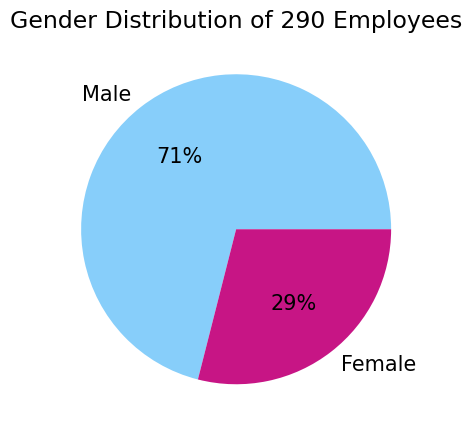

In [7]:
query_1 = """
SELECT SUM(CASE Gender WHEN 'M' THEN 1 ELSE 0 END) AS Male,
	SUM(CASE Gender WHEN 'F' THEN 1 ELSE 0 END) AS Female,
	COUNT(*) AS Total
FROM HumanResources.Employee;
"""

df1 = pd.read_sql(sql=query_1, con=connection)

print(df1.head())

fig, ax1= plt.subplots(figsize = (5,6))

ax1.pie([df1.Male[0], df1.Female[0]], labels=['Male', 'Female'], autopct='%1.f%%', colors=['lightskyblue', 'mediumvioletred'], textprops={'fontsize': 15})
ax1.set_title(f'Gender Distribution of {df1.Total[0]} Employees', fontsize = 17)
plt.show()

## Human Resources:
Q2 Hur ser åldersfördelningen ut på företaget? (Blandad erfarenhet är viktig!)

   Age  NbrOfEmployees
0   23               3
1   24               9
2   25              14
3   26              14
4   27              16


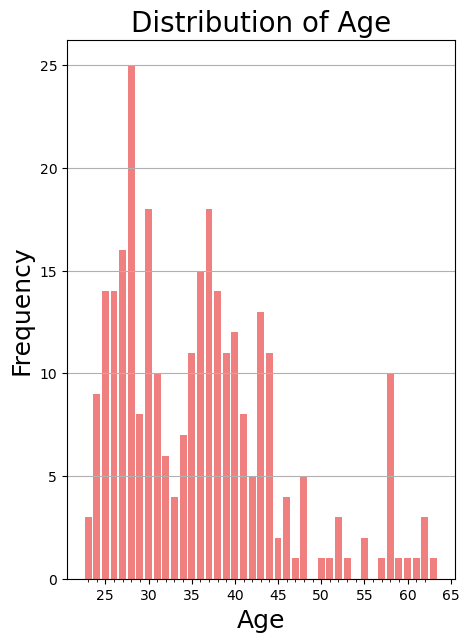

In [8]:
query_2 = """
SELECT DATEDIFF(year, BirthDate, '2014-06-30') AS Age,
	COUNT(DATEDIFF(year, BirthDate, '2014-06-30')) AS NbrOfEmployees
FROM HumanResources.Employee
GROUP BY DATEDIFF(year, BirthDate, '2014-06-30');
"""
df2 = pd.read_sql(sql=query_2, con=connection)

print(df2.head())

# Visualisering Barplot

fig, ax2= plt.subplots(figsize = (5,7))

ax2.bar(df2.Age, df2.NbrOfEmployees, color='lightcoral')
ax2.set_xlabel('Age', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_title('Distribution of Age', fontsize=20)
ax2.yaxis.grid()
ax2.set_xticks(np.arange(df2.Age.min(), df2.Age.max(), 1), minor=True)
plt.show()

## Sales:
Q3 Antal unika registrerade kunder fördelade på Store/Non-Store? (Olika kundtyper kan ha olika köpmönster!)

In [9]:
query_3 = """
SELECT COUNT(CustomerID) AS NbrRegistererdCustomers,
	COUNT(DISTINCT(StoreID)) AS NbrOfStores,
	COUNT(CustomerID)-COUNT(DISTINCT(StoreID)) AS NbrOfOther
FROM Sales.Customer
"""

df3 = pd.read_sql(sql=query_3, con=connection)

print(df3.head())

   NbrRegistererdCustomers  NbrOfStores  NbrOfOther
0                    19820          701       19119


## Sales:
Q4 Medelvärde för antal ordrar/kundtyp, samt medelvärde orderfaktura/kundtyp.
- delar in medelvärde för Store respektive Non Store. Detta för att inte blanda kundtypers attribut.

   AvgOrderPerStore  AvgOrderPerOther  AvgOrderSumStore  AvgOrderSumPerson
0                 5                 1         126752.29          1588.3292


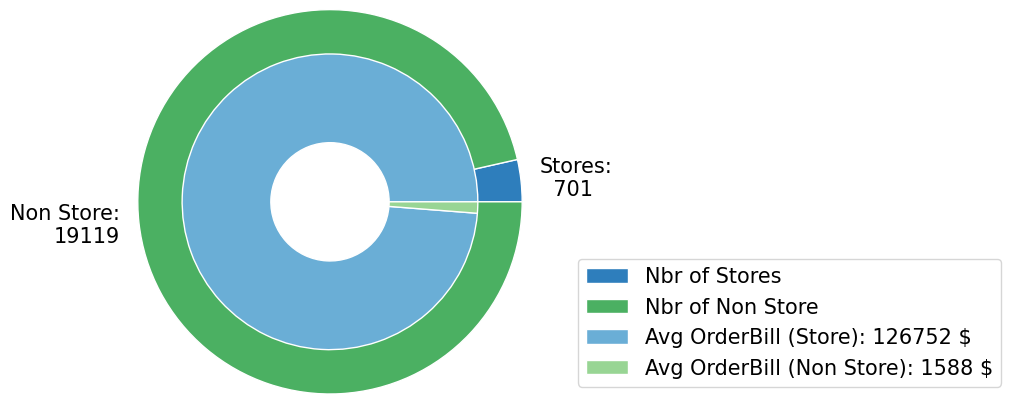

In [10]:
query_4 = """
SELECT AVG(A.NbrSalesStore) AS AvgOrderPerStore, 
		AVG(A.NbrSalesPerson) AS AvgOrderPerOther,
		AVG(A.OrderSumStore) AS AvgOrderSumStore,
		AVG(A.OrderSumPerson) AS AvgOrderSumPerson
FROM 	(SELECT CASE WHEN A.StoreID IS NOT NULL THEN COUNT(B.SalesOrderID) END AS NbrSalesStore,
			CASE WHEN A.StoreID IS NULL THEN COUNT(B.SalesOrderID) END AS NbrSalesPerson,
			CASE WHEN A.StoreID IS NOT NULL THEN SUM(B.SubTotal) END AS OrderSumStore,
			CASE WHEN A.StoreID IS NULL THEN SUM(B.SubTotal) END AS OrderSumPerson,
			A.StoreID,
			A.PersonID,
			A.CustomerID
		FROM Sales.Customer AS A
			JOIN Sales.SalesOrderHeader AS B
				ON A.CustomerID = B.CustomerID
		GROUP BY A.CustomerID, A.StoreID, A.PersonID) AS A
"""

df4 = pd.read_sql(sql=query_4, con=connection)

print(df4.head())

# Visualisering Q3 and Q4 nested pie-chart

group_names=[f'Stores:\n  {df3.NbrOfStores[0]}', f'Non Store:\n{df3.NbrOfOther[0]}']
group_size=np.array([df3.NbrOfStores, df3.NbrOfOther]).flatten()
subgroup_names=f'{df4.AvgOrderPerStore[0]}/Store', f'{df4.AvgOrderPerOther[0]}/Non Store'
subgroup_size=np.array([df4.AvgOrderSumStore, df4.AvgOrderSumPerson]).flatten()

# Create colors
a, b=[plt.cm.Blues, plt.cm.Greens]

# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors= 
[a(0.7), b(0.6)], textprops={'fontsize': 15} )
plt.setp( mypie, width=0.5, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labeldistance=0.5, colors=[a(0.5), b(0.4)])
plt.setp( mypie2, width=0.6, edgecolor='white')
plt.margins(0,0)

subgroup_names_legs=['Nbr of Stores', 'Nbr of Non Store', f'Avg OrderBill (Store): {df4.AvgOrderSumStore[0]:.0f} $',
                     f'Avg OrderBill (Non Store): {df4.AvgOrderSumPerson[0]:.0f} $']
plt.legend(subgroup_names_legs,loc=(1,0), fontsize = 15)

plt.show()

# Referenser
#https://stackoverflow.com/questions/55267993/add-legends-to-nested-pie-charts (OBS - använd mall)
#https://matplotlib.org/stable/gallery/pie_and_polar_charts/nested_pie.html

## Sales:
Q5 Hur har försäljning sett ut per kategori? (Viktigaste kategorin för företag)
- Noterar att ListPrices har ändrats max 13 %. Detta resultat antas vara försumbart.

Kod för undersökning av ListPrices:\
"""
  SELECT ProductID,
	(MAX(Listprice)-MIN(ListPrice))/MIN(ListPrice) AS Diff
  FROM Production.ProductListPriceHistory
  GROUP BY ProductID
  HAVING (MAX(Listprice)-MIN(ListPrice))/MIN(ListPrice) > 0.10;
"""

   ProductID  OrderQty  StandardCost  ListPrice  UnitProfit   TotalProfit  \
0        793     22988     1554.9479    2443.35    888.4021  2.042259e+07   
1        794     20972     1554.9479    2443.35    888.4021  1.863157e+07   
2        795     17430     1554.9479    2443.35    888.4021  1.548485e+07   
3        976     22708     1082.5100    1700.99    618.4800  1.404444e+07   
4        753      9296     2171.2942    3578.27   1406.9758  1.307925e+07   

     Category  
0  Components  
1  Components  
2  Components  
3  Components  
4  Components  

Låter Pandas summerar map Category (genom groupby):

             ProductID  OrderQty  StandardCost  ListPrice  UnitProfit  \
Category                                                                
Accessories       5944     47400      234.9650    529.200    294.2350   
Bikes            27842     84963    29880.6408  53867.680  23987.0392   
Clothing         21207    118008    19490.5544  31355.460  11864.9056   
Components       34913

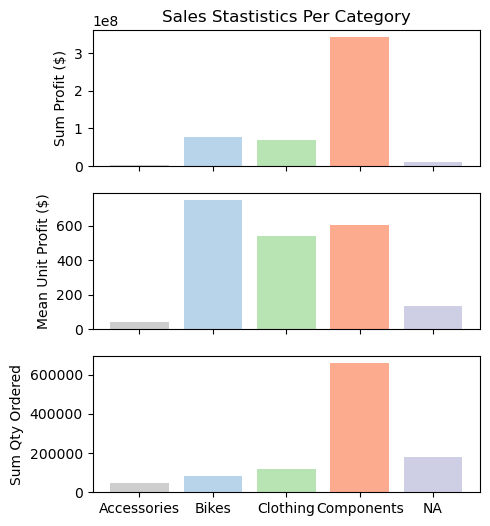

In [11]:
query_5 = """
SELECT A.ProductID,
	SUM(A.OrderQty) AS OrderQty,
	B.StandardCost,
	B.ListPrice,
	B.ListPrice-B.StandardCost AS UnitProfit,
	(B.ListPrice-B.StandardCost)*SUM(A.OrderQty) AS TotalProfit,
	CASE WHEN C.[Name] IS NULL THEN 'NA' ELSE C.[NAME] END AS Category
FROM Sales.SalesOrderDetail AS A
	INNER JOIN Production.Product AS B
		ON A.ProductID = B.ProductID
	LEFT JOIN (
				SELECT A.ProductID,
					A.ProductSubcategoryID,
					B.ProductCategoryID,
					C.[Name]
				FROM Production.Product AS A
					JOIN Production.ProductSubcategory AS B
						ON A.ProductSubcategoryID = B.ProductCategoryID
					JOIN Production.ProductCategory AS C
						ON B.ProductCategoryID = C.ProductCategoryID
				) AS C
		ON B.ProductID = C.ProductID
GROUP BY A.ProductID, B.StandardCost, B.ListPrice, C.[Name]
ORDER BY TotalProfit DESC
"""

df5 = pd.read_sql(sql=query_5, con=connection)

print(df5.head())

print()
print("Låter Pandas summerar map Category (genom groupby):")

df5_groupby = df5.groupby(['Category']).sum() #OBS bara OrderQty och TotalProfit som är av intresse i denna gruppering

print()
print(df5_groupby.head())

# Visualisering 3 stackade barplots

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (5,6), sharex=True)

tone = 0.3
colors = [plt.cm.Greys(tone), plt.cm.Blues(tone), plt.cm.Greens(tone), plt.cm.Reds(tone), plt.cm.Purples(tone)]

ax1.bar(df5_groupby.index.values, df5_groupby.TotalProfit, color = colors)
ax2.bar(df5_groupby.index.values, df5.groupby(['Category']).mean().UnitProfit, color = colors)
ax3.bar(df5_groupby.index.values, df5_groupby.OrderQty, color = colors)

ax1.set_ylabel('Sum Profit ($)')
ax2.set_ylabel('Mean Unit Profit ($)')
ax3.set_ylabel('Sum Qty Ordered')
ax1.set_title('Sales Stastistics Per Category')

plt.show()

## Person:
Q6 Var finns/finns inte kunder/företaget representerat? (Var finns potentiella nya marknader?)
- Är antalet Sales Person/Kund (per land) ungefär samma?
- Vilka länder finns företaget inte i?

In [12]:
query_6 = """
SELECT CASE WHEN A.PersonType = 'IN' THEN 'Individual (retail) customer' WHEN A.PersonType = 'SP' THEN 'Sales Person' END AS PersonType,
	CASE WHEN E.[Name] = 'United States' THEN 'United States of America' ELSE E.[Name] END AS Country,
	COUNT(A.PersonType) AS Nbr
FROM Person.Person AS A
	JOIN Person.BusinessEntityAddress AS B
		ON A.BusinessEntityID = B.BusinessEntityID
	JOIN Person.Address AS C
		ON B.AddressID = C.AddressID
	JOIN Person.StateProvince AS D
		ON C.StateProvinceID = D.StateProvinceID
	JOIN Person.CountryRegion AS E
		ON D.CountryRegionCode = E.CountryRegionCode
GROUP BY A.PersonType, E.[Name]
HAVING PersonType IN('IN','SP')
ORDER BY Country DESC, PersonType;
"""

df6 = pd.read_sql(sql=query_6, con=connection)

print(df6)

                      PersonType                   Country   Nbr
0   Individual (retail) customer  United States of America  7843
1                   Sales Person  United States of America    11
2   Individual (retail) customer            United Kingdom  1913
3                   Sales Person            United Kingdom     1
4   Individual (retail) customer                   Germany  1780
5                   Sales Person                   Germany     1
6   Individual (retail) customer                    France  1810
7                   Sales Person                    France     1
8   Individual (retail) customer                    Canada  1571
9                   Sales Person                    Canada     2
10  Individual (retail) customer                 Australia  3591
11                  Sales Person                 Australia     1


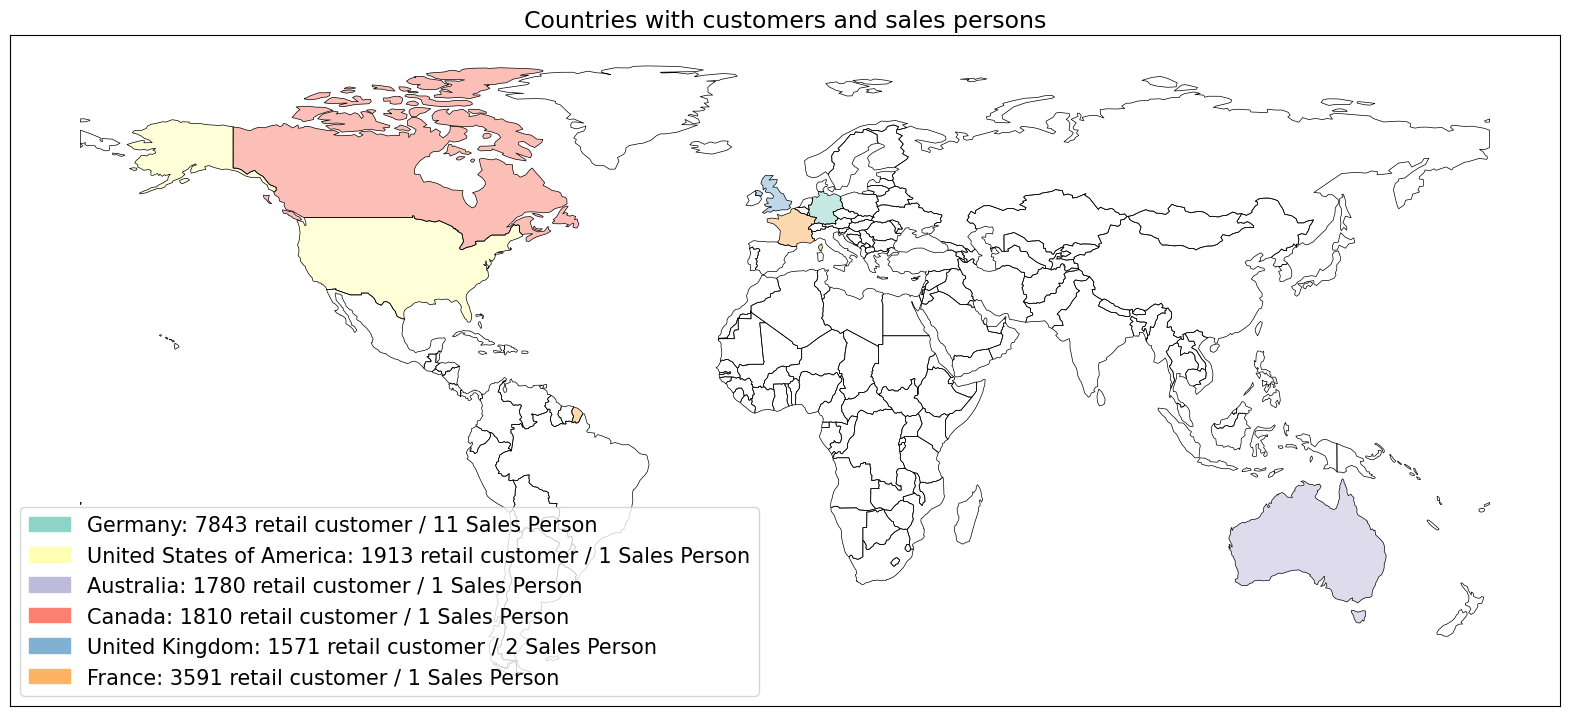

In [13]:
# Visualisering av Q6

# load the low resolution world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Step 1, göra en basic world map
fig, ax = plt.subplots(figsize=(20, 10))

# drop "Antarctica" and "Seven seas" from the dataframe (which will make our
# world map visualization a bit prettier)
drop_idxs = world["continent"].isin([
    "Antarctica",
    "Seven seas (open ocean)"
])
world = world.drop(world[drop_idxs].index)

# plot a basic map of the world
world.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.5
)

# Step 2
# grab the unique set countries, generate a unique color for each one,
# and initialize the list of patches
# använd SQL data för legends

countries = list(set(df6.Country.to_list()))

sales_persons = df6[df6["PersonType"] == 'Sales Person'].Nbr
customers = df6[df6["PersonType"] == 'Individual (retail) customer'].Nbr

colors = sns.color_palette("Set3", len(countries))
patches = []

# loop over the continent names and corresponding colors
for (country_name, color, nbr_sales_person, nbr_customers) in list(zip(countries, colors, sales_persons, customers)):
    # grab all countries that belong to the continent, then plot each of the
    # continents, giving each a unique color

    countries = world[world['name'] == country_name]
    countries.plot(ax=ax, color=color, alpha=0.5)

    # generate a patch for the current continent
    patch = mpatches.Patch(label=f"{country_name}: {nbr_customers} retail customer / {nbr_sales_person} Sales Person", color=color)
    patches.append(patch)

# add the patches to the map
ax.legend(handles=patches, loc="lower left", fontsize=15)

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# set the plot title
plt.title("Countries with customers and sales persons", fontsize=17)
plt.show()


#Referenser
#https://naturaldisasters.ai/posts/python-geopandas-world-map-tutorial/

## Production:
Q7 Hur följs produktionens planerade arbetstid per locationtyp? (Förbättringspotential i produktion!)
- Är verklig tid > planerad tid för framställning av produkter per locationtyp?

                 Name Completed  TotalQuant
1    Debur and Polish   On Time        1083
3      Final Assembly   On Time       19013
5       Frame Forming   On Time       27988
7       Frame Welding   On Time       10048
9               Paint   On Time         592
11  Specialized Paint   On Time         491
13        Subassembly   On Time       90743
                 Name    Completed  TotalQuant
0    Debur and Polish  Longer Time       12928
2      Final Assembly  Longer Time      175534
4       Frame Forming  Longer Time      289323
6       Frame Welding  Longer Time       98181
8               Paint  Longer Time        7853
10  Specialized Paint  Longer Time        5075
12        Subassembly  Longer Time      867107


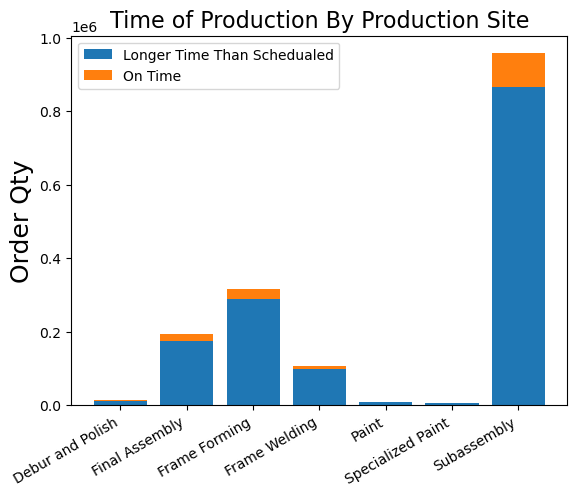

In [14]:
query_7 = """
SELECT C.[Name],
	--B.ProductID,
	CASE WHEN DATEDIFF(day, A.ScheduledStartDate, A.ScheduledEndDate) < DATEDIFF(day, A.ActualStartDate, A.ActualEndDate) THEN 'Longer Time' ELSE 'On Time' END AS Completed,
	SUM(B.OrderQty) AS TotalQuant
FROM Production.WorkOrderRouting AS A
	JOIN Production.WorkOrder AS B
		ON A.WorkOrderID = B.WorkOrderID
	JOIN Production.Location AS C
		ON A.LocationID = C.LocationID
GROUP BY C.[Name], CASE WHEN DATEDIFF(day, A.ScheduledStartDate, A.ScheduledEndDate) < DATEDIFF(day, A.ActualStartDate, A.ActualEndDate) THEN 'Longer Time' ELSE 'On Time' END
ORDER BY C.[Name] , CASE WHEN DATEDIFF(day, A.ScheduledStartDate, A.ScheduledEndDate) < DATEDIFF(day, A.ActualStartDate, A.ActualEndDate) THEN 'Longer Time' ELSE 'On Time' END
"""

df7 = pd.read_sql(sql=query_7, con=connection)

on_times = df7[df7['Completed'] == 'On Time']
longer_times = df7[df7['Completed'] == 'Longer Time']
print(on_times)
print(longer_times)


# Data
groups = list(longer_times.Name)
values1 = longer_times.TotalQuant
values2 = on_times.TotalQuant

fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(groups, values1, label = 'Longer Time Than Schedualed')
ax.bar(groups, values2, bottom = values1, label = "On Time")

ax.set_ylabel('Order Qty', fontsize=18)
ax.set_title('Time of Production By Production Site', fontsize=16)
ax.set_xticklabels(longer_times.Name, rotation=30, horizontalalignment='right')

ax.legend()

plt.show()

#Referens
#https://python-charts.com/part-whole/stacked-bar-chart-matplotlib/

## Purchase:
Q8 Hur många produkter återförsäljs i portföljen?

In [15]:
query_8 = """
SELECT COUNT(DISTINCT(A.ProductID)) AS [Retailed Products],
	COUNT(DISTINCT(B.ProductID)) AS [Total Products in Portfolio],
    100*COUNT(DISTINCT(A.ProductID))/COUNT(DISTINCT(B.ProductID)) AS [Retailed Products (%)]
FROM Purchasing.ProductVendor AS A, Production.Product AS B
"""

df8 = pd.read_sql(sql=query_8, con=connection)

print(df8)

df8[''] = 'Amount'
df8.set_index('', inplace = True)

df8


   Retailed Products  Total Products in Portfolio  Retailed Products (%)
0                265                          504                     52


,Retailed Products,Total Products in Portfolio,Retailed Products (%)
,,,
Amount,265,504,52


## Purchase:
Q9 Vilka är top 10 viktigaste Vendors map kvantitet? (Vilka Vendor kan man jobba närmare med för bättre rabatt?)
- tidigare queries har visat att t ex  kvantitet varit viktigt för total profit.

                              Vendor  TotalOrderQty
0                    SUPERSALES INC.         125000
1                Custom Frames, Inc.         115500
2               Chicago City Saddles          98450
3                      Victory Bikes          79200
4  Professional Athletic Consultants          78100
5                     Circuit Cycles          69300
6           Compete Enterprises, Inc          69300
7                      Compete, Inc.          68750
8                First Rate Bicycles          67650
9  Electronic Bike Repair & Supplies          67100


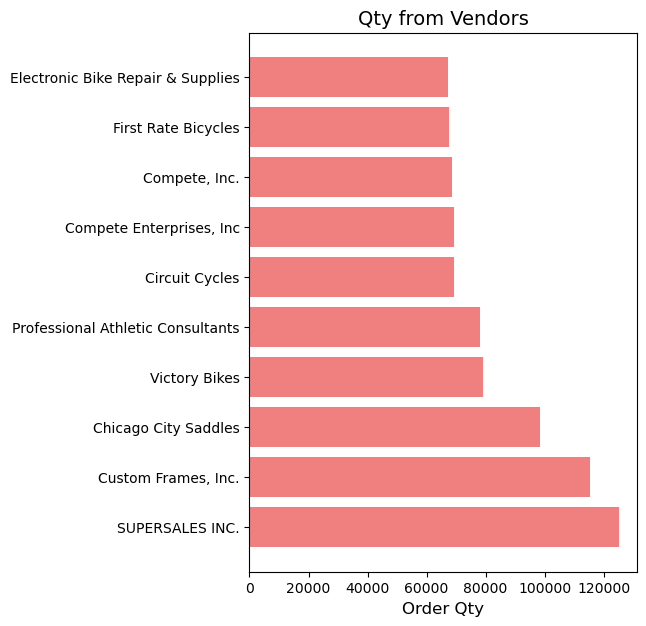

In [16]:
query_9 = """
SELECT TOP(10) A.[Name] AS Vendor,
	SUM(C.OrderQty) AS TotalOrderQty
FROM Purchasing.Vendor AS A
	JOIN Purchasing.PurchaseOrderHeader AS B
		ON A.BusinessEntityID = B.VendorID
	JOIN Purchasing.PurchaseOrderDetail AS C
		ON B.PurchaseOrderID = C.PurchaseOrderID
GROUP BY A.[NAME]
ORDER BY TotalOrderQty DESC;
"""

df9 = pd.read_sql(sql=query_9, con=connection)

print(df9)

# Visualisering barplot

fig, ax = plt.subplots(figsize = (5,7))

ax.barh(df9.Vendor, df9.TotalOrderQty, color='lightcoral')
ax.set_xlabel('Order Qty', fontsize=12)
ax.set_title('Qty from Vendors', fontsize=14)

plt.show()

# 2. Statistisk analys (konfidensintervall)

## Sales:
Q10 Vilken produkt har gett mest profit i kategori 'Bikes'?
- Fördjupning från Query 5: Vi såg att Bikes hade högst medelvärde för UnitProfit, men hade låg QtyOrder. Kan vi undersöka varför låg Qty för bäst säljande i kategori 'Bikes' kanske vi kan få en insikt!

In [17]:
query_10 = """
SELECT TOP(1) B.[Name],
	A.ProductID,
	SUM(A.OrderQty) AS OrderQty,
	B.StandardCost,
	B.ListPrice,
	B.ListPrice-B.StandardCost AS UnitProfit,
	(B.ListPrice-B.StandardCost)*SUM(A.OrderQty) AS TotalProfit,
	CASE WHEN C.[Name] IS NULL THEN 'NA' ELSE C.[NAME] END AS Category
FROM Sales.SalesOrderDetail AS A
	INNER JOIN Production.Product AS B
		ON A.ProductID = B.ProductID
	LEFT JOIN (
				SELECT A.ProductID,
					A.ProductSubcategoryID,
					B.ProductCategoryID,
					C.[Name]
				FROM Production.Product AS A
					JOIN Production.ProductSubcategory AS B
						ON A.ProductSubcategoryID = B.ProductCategoryID
					JOIN Production.ProductCategory AS C
						ON B.ProductCategoryID = C.ProductCategoryID
				) AS C
		ON B.ProductID = C.ProductID
GROUP BY A.ProductID, B.StandardCost, B.ListPrice, C.[Name], B.[Name]
HAVING C.[Name] = 'Bikes'
ORDER BY TotalProfit DESC
"""

# Skapa Queries
df10 = pd.read_sql(sql=query_10, con=connection)

print(df10.head())
print()
print(f"{df10.Name[0]} i kategori {df10.Category[0]} har gett mest profit")

                     Name  ProductID  OrderQty  StandardCost  ListPrice  \
0  Mountain-200 Black, 38        782      8931     1251.9813    2294.99   

   UnitProfit   TotalProfit Category  
0   1043.0087  9.315111e+06    Bikes  

Mountain-200 Black, 38 i kategori Bikes har gett mest profit


## Q11 Hur har försäljning sett ut historiskt map QTY?
- För produkt i Q10.
- Konfidensintervall beräknas här för det är svårt att visuellt avgöra var genomsnittliga månadsförsäljning skulle ligga.
- Konfidensintervall säger att den fixa med okända genomsnittliga månadsförsäljningen ligger inom intervallet med 95 % sannolikhet.
- Kollar även av att data är normalfördelad med shapiro-wilks test och histogram.

    ProductID  OrderQty   Period
15        782        89   2013-8
16        782       151   2013-9
17        782       134  2013-10
18        782        89  2013-11
19        782       130  2013-12
20        782       150   2014-1
21        782        32   2014-2
22        782       219   2014-3
23        782        52   2014-4
24        782       166   2014-5

Mean: 119.08
Std: 42.08
Median: 130.00
Minimum: 32.00
Maximum: 219.00

(101.70950774822187, 136.45049225177812)

ShapiroResult(statistic=0.9832058548927307, pvalue=0.9403888583183289)


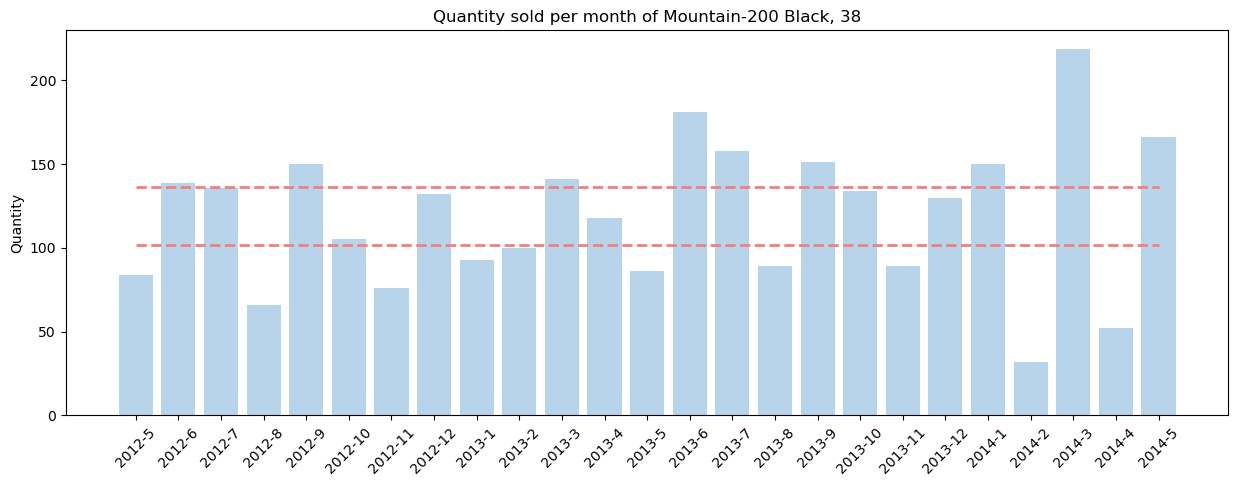

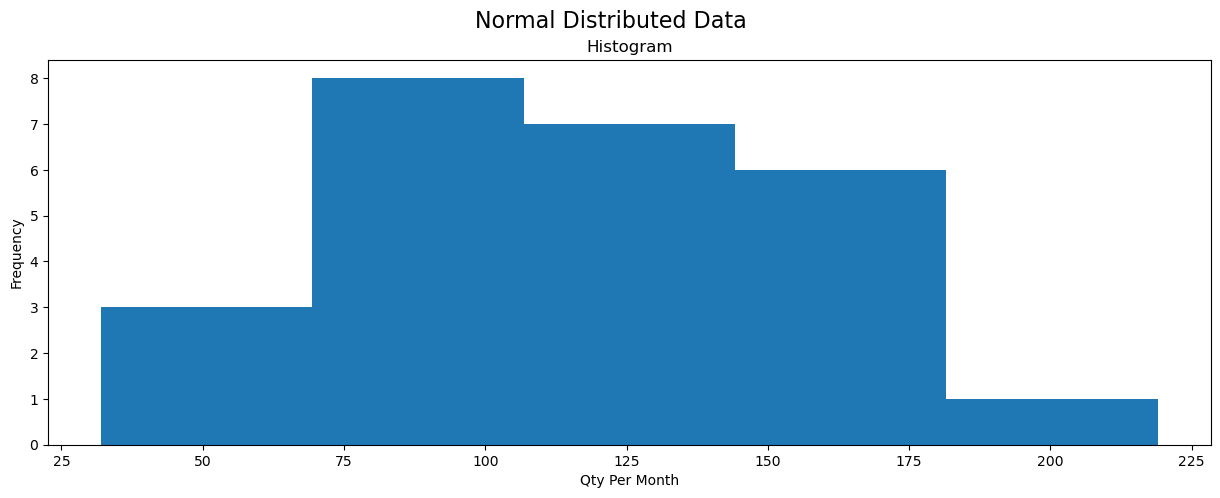

Slutsats: Shapiro-Wilks test säger NF. Histogram är hjälpligt NF: förmodligen för att n = 25 (ganska litet
Dvs okej att antag att data är NF!


In [18]:
query_11 = f"""
SELECT A.ProductID,
	SUM(A.OrderQty) AS OrderQty,
	CONCAT(DATEPART(yy, B.OrderDate),'-',DATEPART(mm, B.OrderDate)) AS [Period]
FROM Sales.SalesOrderDetail AS A
INNER JOIN Sales.SalesOrderHeader AS B
	ON A.SalesOrderID = B.SalesOrderID
GROUP BY DATEPART(yy,B.OrderDate), DATEPART(mm,B.OrderDate), A.ProductID
HAVING A.ProductID = {df10.ProductID[0]}
ORDER BY DATEPART(yy, B.OrderDate);
"""

df11 = pd.read_sql(sql=query_11, con=connection)

print(df11.tail(10))

fig, ax = plt.subplots(figsize=(15, 5))

x = np.array(df11.Period)

ax.bar(x, df11.OrderQty, color=plt.cm.Blues(0.3))
ax.set_ylabel('Quantity')
ax.set_title(f'Quantity sold per month of {df10.Name[0]}')
ax.xaxis.set_tick_params(rotation=45)

print()
print(f'Mean: {np.mean(df11.OrderQty):.2f}')
print(f'Std: {np.std(df11.OrderQty):.2f}')
print(f'Median: {np.median(df11.OrderQty):.2f}')
print(f'Minimum: {np.min(df11.OrderQty):.2f}')
print(f'Maximum: {np.max(df11.OrderQty):.2f}')
print()

n = len(df11)
print(t.interval(0.95, n-1, np.mean(df11.OrderQty), np.std(df11.OrderQty)/np.sqrt(n)))
interval = t.interval(0.95, n-1, np.mean(df11.OrderQty), np.std(df11.OrderQty)/np.sqrt(n))

ax.hlines(y=interval[0], xmin=df11.Period.iloc[0], xmax=df11.Period.iloc[-1], linewidth=2, linestyle='dashed', color='lightcoral')
ax.hlines(y=interval[1], xmin=df11.Period.iloc[0], xmax=df11.Period.iloc[-1], linewidth=2, linestyle='dashed', color='lightcoral')



# Undersöker om data är Normalfördelad
print()
print(st.shapiro(df11.OrderQty))
# H0 = data NF
# H1 = data INTE NF -- om p-värde större än 0.05 kan H0 inte förkastas!

fig, axs = plt.subplots(figsize=(15, 5))
plt.suptitle('Normal Distributed Data', fontsize=16)
axs.hist(df11.OrderQty, 5)
axs.set_xlabel('Qty Per Month')
axs.set_ylabel('Frequency')
axs.set_title('Histogram')

plt.show()

print("Slutsats: Shapiro-Wilks test säger NF. Histogram är hjälpligt NF: förmodligen för att n = 25 (ganska litet")
print("Dvs okej att antag att data är NF!")

## Q12 Kan man öka försäljning (QTY) genom att införa en rabatt?
- hittar QTY för produkter med "rabatterad period" och "ej rabatterad period".
- val av 0.15 % för att då fås tillräckligt stort stickprov.
- val av referens-period direkt efteråt eftersom "1 år senare" inte finns i data.
- beräknar skillnad QtyDiff mellan dessa perioder. Denna kolumn används för hypotestest.

In [19]:
# Q12 - Kan man öka försäljning (QTY) genom att införa en rabatt? Hypotestest

query_12 = """
WITH First_CTE (ProductID, DiscountPct, [Type])
AS
-- Define the first CTE query.
(
	SELECT A.ProductID,
		B.DiscountPct,
		B.[Type]
	FROM Sales.SpecialOfferProduct AS A INNER JOIN Sales.SpecialOffer AS B
		ON A.SpecialOfferID = B.SpecialOfferID
	WHERE Type LIKE '%New Product%' AND DiscountPct = 0.15
)
, -- Use a comma to separate multiple CTE definitions.

-- Define the second CTE query, which returns sales quota data by year for each sales person.
Second_CTE (ProductID, QtyInDiscountPeriod, QtyAfterDiscountPeriod, QtyDiff)
AS
(
	SELECT t1.ProductID, t1.QtyInDiscountPeriod, t2.QtyAfterDiscountPeriod, t1.QtyInDiscountPeriod-t2.QtyAfterDiscountPeriod AS QtyDiff
	FROM (SELECT A.ProductID, SUM(A.OrderQty) AS QtyInDiscountPeriod
		FROM Sales.SalesOrderDetail AS A
		INNER JOIN Sales.SalesOrderHeader AS B
			ON A.SalesOrderID = B.SalesOrderID
		WHERE (B.OrderDate BETWEEN '2013-05-30'AND '2013-08-29')
		GROUP BY A.ProductID) as t1,
		(SELECT
			A.ProductID,
			SUM(A.OrderQty) AS QtyAfterDiscountPeriod
		FROM Sales.SalesOrderDetail AS A
		INNER JOIN Sales.SalesOrderHeader AS B
			ON A.SalesOrderID = B.SalesOrderID
		WHERE (B.OrderDate BETWEEN '2013-08-30'AND '2013-11-29')
		GROUP BY A.ProductID) as t2
	WHERE t1.ProductID = t2.ProductID
)
-- Define the outer query by referencing columns from both CTEs.
SELECT First_CTE.ProductID, 
	First_CTE.DiscountPct, 
	First_CTE.[Type], 
	Second_CTE.QtyInDiscountPeriod, 
	Second_CTE.QtyAfterDiscountPeriod, 
	Second_CTE.QtyDiff
FROM First_CTE
	INNER JOIN Second_CTE
		ON First_CTE.ProductID = Second_CTE.ProductID
ORDER BY ProductID;
"""

# CTE ovan innehåller nested subquery, se formen nedan:
"""
WITH A_CTE
AS
    (Table1)
,
WITH B_CTE
AS
    (Table2),
SELECT A.Column1,
    B.Column2
FROM A.CTE
    INNER JOIN B.CTE
        ON A.CTE.SomeColumn = B.CTE.SomeColumn;
        
Där Table2 har subqueries:
    SELECT t1.ColumnA, t2.ColumnB
    FROM (query1) as t1, (query2) as t2
    WHERE t1.ProductID = t2.ProductID;
"""

# Skapa Queries
df12 = pd.read_sql(sql=query_12, con=connection)

print(df12.head(10))

# df12.QtyDiff används i hypotes test i följande cell!

   ProductID  DiscountPct         Type  QtyInDiscountPeriod  \
0        958         0.15  New Product                  204   
1        959         0.15  New Product                  134   
2        960         0.15  New Product                   62   
3        961         0.15  New Product                  241   
4        962         0.15  New Product                  202   
5        963         0.15  New Product                  126   
6        964         0.15  New Product                   93   
7        965         0.15  New Product                  245   
8        978         0.15  New Product                   87   
9        979         0.15  New Product                  249   

   QtyAfterDiscountPeriod  QtyDiff  
0                     169       35  
1                     124       10  
2                      68       -6  
3                     218       23  
4                     173       29  
5                     119        7  
6                      62       31  
7         

# Hypotestest:
###    H0: my = 0
###   H1: my > 0
###    Om p-värde > 0.05 förkastas ej H0.

In [20]:
n = len(df12)
t_krit = 1.833 # t-fördelning 10-1 = 9 f.g.

mean = df12.QtyDiff.mean()
std = np.std(df12.QtyDiff, ddof=1)
t_obs = (mean - 0)/(std/np.sqrt(n))

print()
print("Räkna manuellt")
print('mean=', mean)
print('std=', std)
print('n=', n)
print('t_krit=', t_krit)
print('t_obs=', t_obs)
print()

# Använder scipy.stats
print("Använd inbyggd funktion:")
print(st.ttest_1samp(np.array(df12.QtyDiff), 0, alternative='greater'))
print()
print("Slutsats:")
print('p-värde är mindre än 0.05! --> Förkasta H0. Det finns en påvisad ökning av kvantitet när man har rabatt!')
print()
print("Kontrollera antagandet om NF, NF om p-värde > 0.05:") 
print(st.shapiro(df12.QtyDiff))


Räkna manuellt
mean= 21.5
std= 13.729530217745982
n= 10
t_krit= 1.833
t_obs= 4.952024476827446

Använd inbyggd funktion:
TtestResult(statistic=4.952024476827446, pvalue=0.0003945532561235745, df=9)

Slutsats:
p-värde är mindre än 0.05! --> Förkasta H0. Det finns en påvisad ökning av kvantitet när man har rabatt!

Kontrollera antagandet om NF, NF om p-värde > 0.05:
ShapiroResult(statistic=0.8781086802482605, pvalue=0.12411831319332123)
